# Self-Driving Car Engineer Nanodegree


## Project: Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Import section

In [1]:
# Import section
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

%matplotlib inline

/home/vianney/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Get vehicles and non vehicles file names
vehicles_image_path = glob.glob("vehicles/**/*.png", recursive=True)
not_vehicles_image_path = glob.glob("non_vehicles/**/*.png", recursive=True)
print("Vehicles amount:", len(vehicles_image_path))
print("Not vehicles amount:", len(not_vehicles_image_path))

Vehicles amount: 8799
Not vehicles amount: 8968


In [3]:
# Function that flips an input image
def flip_image(image):
    '''
    This function flips the image
    '''
    flipped_image = np.copy(image)
    flipped_image = cv2.flip(flipped_image, 1)
    return flipped_image

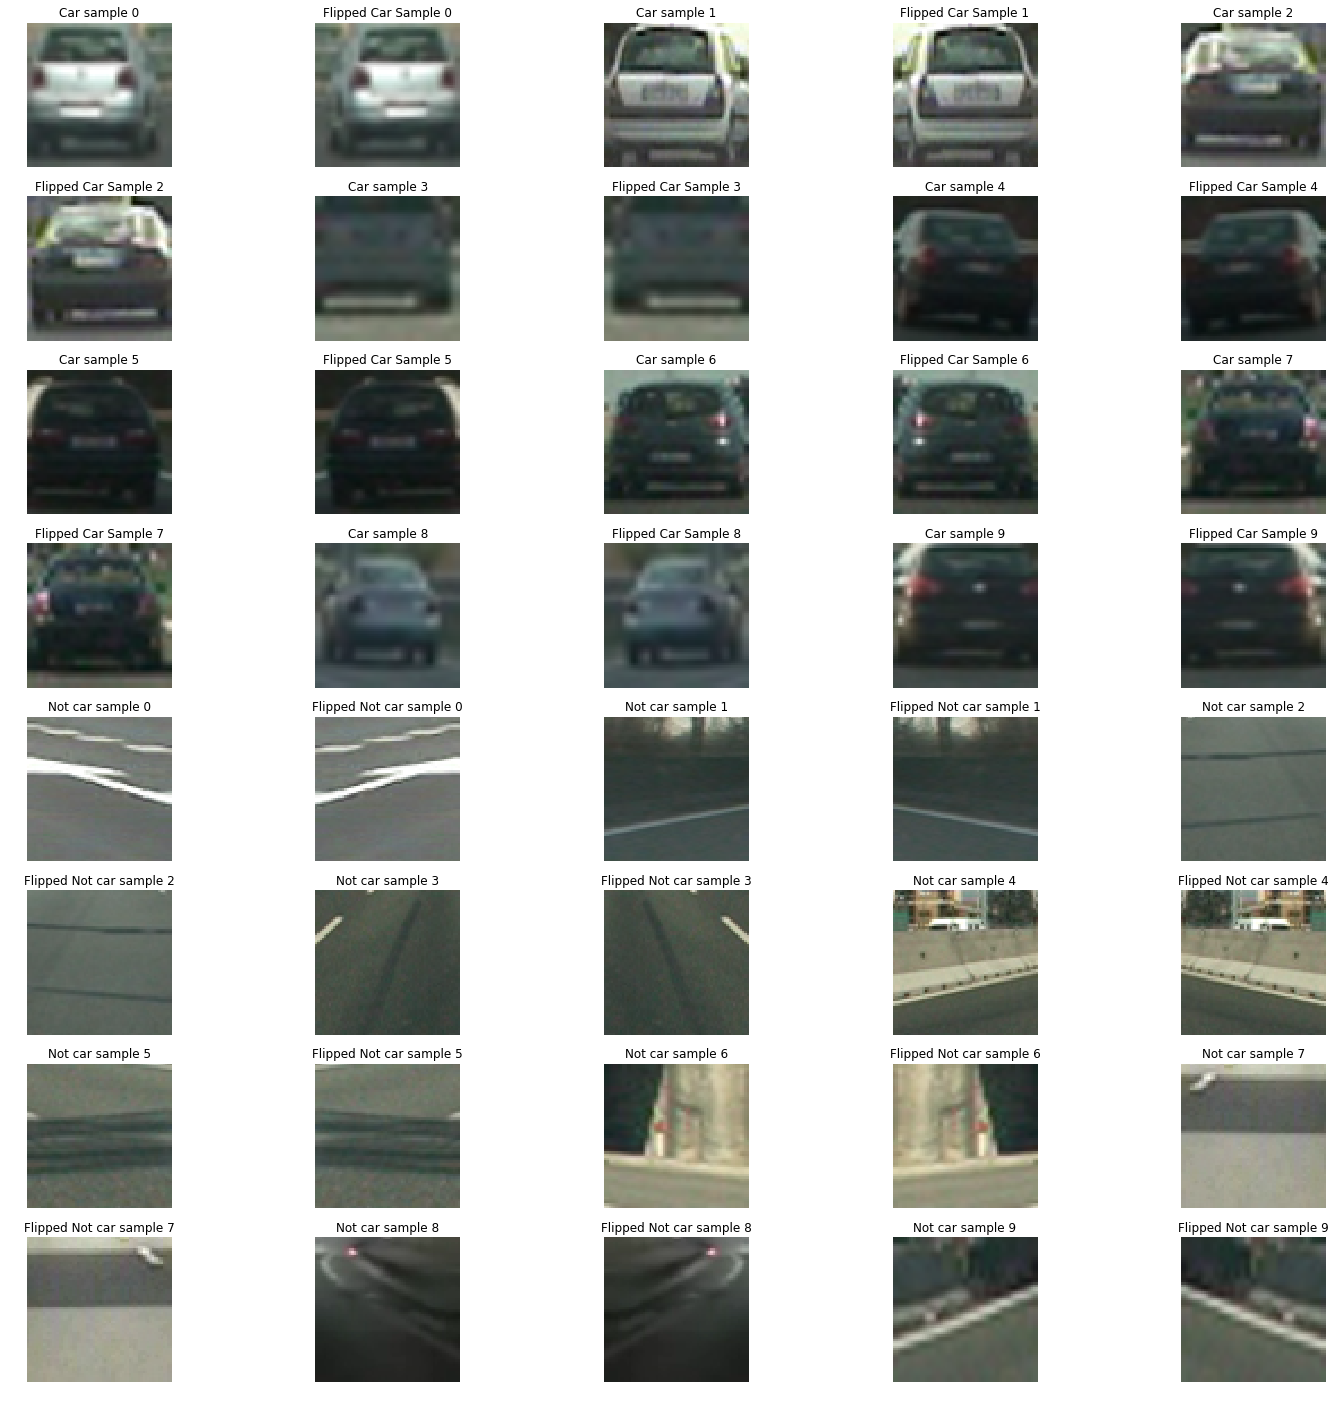

In [4]:
# Show 10 samples of each of the data sets
samples = 10

fig, axs = plt.subplots(8, 5, figsize=(25, 25))
axs = axs.ravel()
car_samples, not_car_samples = [], []

for image_index in range(samples):
    original_image = mpimg.imread(vehicles_image_path[image_index])
    flipped_image = flip_image(original_image)
    car_samples.append(original_image)
    car_samples.append(flipped_image)
    # Show original image from disk
    axs[image_index*2].imshow(original_image)
    axs[image_index*2].axis('off')
    axs[image_index*2].set_title("Car sample " + str(image_index))
    # Show flipped from original image
    axs[image_index*2+1].imshow(flipped_image)
    axs[image_index*2+1].axis('off')
    axs[image_index*2+1].set_title("Flipped Car Sample " + str(image_index))
    
for image_index in range(samples):
    original_image = mpimg.imread(not_vehicles_image_path[image_index])
    flipped_image = flip_image(original_image)
    not_car_samples.append(original_image)
    not_car_samples.append(flipped_image)
    # Show original image from diskge_path[image_index])
    axs[image_index*2 + samples*2].imshow(original_image)
    axs[image_index*2 + samples*2].axis('off')
    axs[image_index*2 + samples*2].set_title("Not car sample " + str(image_index))
    # Show flipped from original image
    axs[image_index*2 + samples*2 + 1].imshow(flipped_image)
    axs[image_index*2 + samples*2 + 1].axis('off')
    axs[image_index*2 + samples*2 + 1].set_title("Flipped Not car sample " + str(image_index))

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=False
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

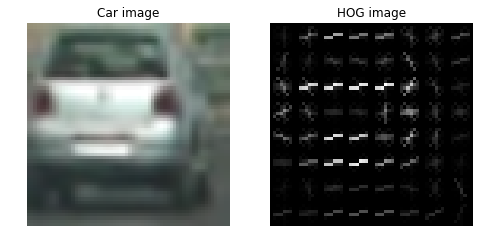

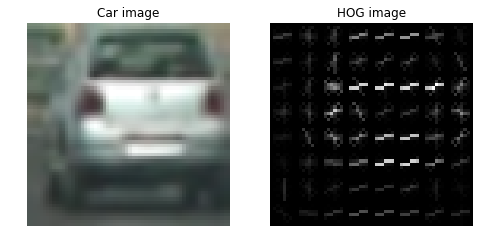

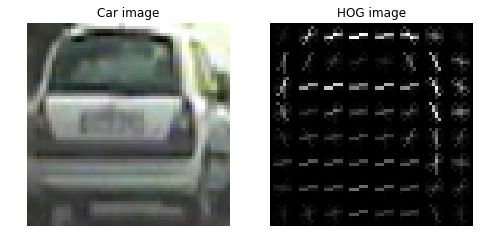

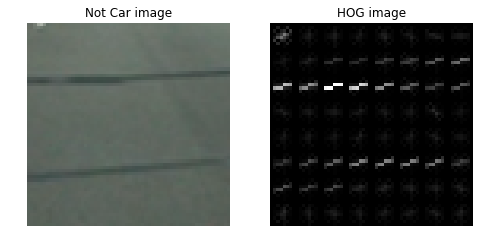

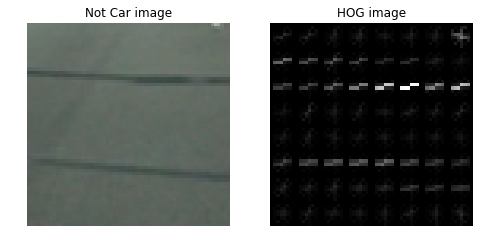

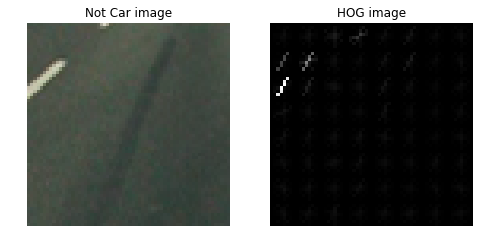

In [9]:
# Extract the HOG feature of some samples and show them
hog_samples = []
for car in car_samples[:3]:
    features, hog_image = get_hog_features(car[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
    hog_samples.append(hog_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs = axs.ravel()
    axs[0].imshow(car)
    axs[0].axis('off')
    axs[0].set_title("Car image")
    
    axs[1].imshow(hog_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("HOG image")
    
for not_car in not_car_samples[4:7]:
    features, hog_image = get_hog_features(not_car[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
    hog_samples.append(hog_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs = axs.ravel()
    axs[0].imshow(not_car)
    axs[0].axis('off')
    axs[0].set_title("Not Car image")
    
    axs[1].imshow(hog_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("HOG image")

In [10]:
# Parameters to tune for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 10 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Extract features from the vehicle images
car_features = extract_features(vehicles_image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# Extract features from the non vehicle images
notcar_features = extract_features(not_vehicles_image_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Car data length:", len(car_features))
print("Not Car data length:", len(notcar_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Car data length: 8799
Not Car data length: 8968
Using: 12 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 4416


In [11]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
# Train the classifier
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

10.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9792


In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        #9) Return concatenated array of features
    return np.concatenate(img_features)

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [16]:
# Get test images filenames
test_images_path = glob.glob("test_images/*.jpg")
test_images = []
for image_path in test_images_path:
    test_images.append(mpimg.imread(image_path))

In [161]:
# Get windows were cars are found
def search_cars_windows(image, jpg=False, xy_window=(64, 64), y_start_stop = [400, 480], color=(0, 0, 255), x_start_stop=[None, None]):
    draw_image = np.copy(image)
    slided_image = np.copy(image)
    if jpg == True:
        slided_image = image.astype(np.float32)/255
    windows = slide_window(slided_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                           xy_window=xy_window, xy_overlap=(0.80, 0.80))

    hot_windows = search_windows(slided_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    return hot_windows

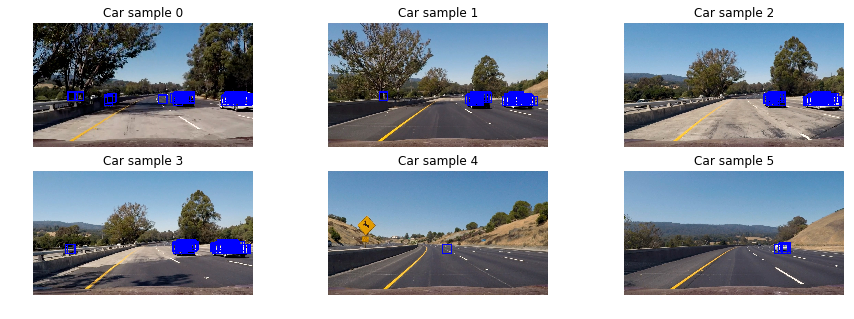

In [162]:
# Show somes examples using a 50x50 window
cars_images = []
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()
for image_index, test_image in enumerate(test_images):
    windows = search_cars_windows(test_image, jpg=True, xy_window=(50, 50))
    window_img = draw_boxes(test_image, windows, thick=6)
    cars_images.append(window_img)
    axs[image_index].imshow(window_img)
    axs[image_index].axis('off')
    axs[image_index].set_title("Car sample " + str(image_index))

In [163]:
# Draw slicing windows on top of the given image
def sample_image_slicing(image, jpg=False, xy_window=(50, 50), y_start_stop=[400, 600], color=(0, 0, 255), x_start_stop=[None, None]):
    draw_image = np.copy(image)
    slided_image = np.copy(image)
    if jpg == True:
        slided_image = image.astype(np.float32)/255
    windows = slide_window(slided_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                           xy_window=xy_window, xy_overlap=(0.80, 0.80))

    window_img = draw_boxes(draw_image, windows, color=color, thick=6)
    return window_img

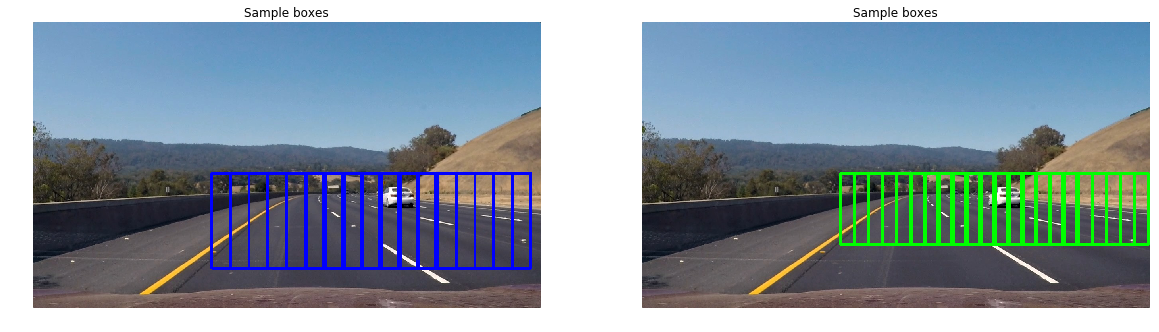

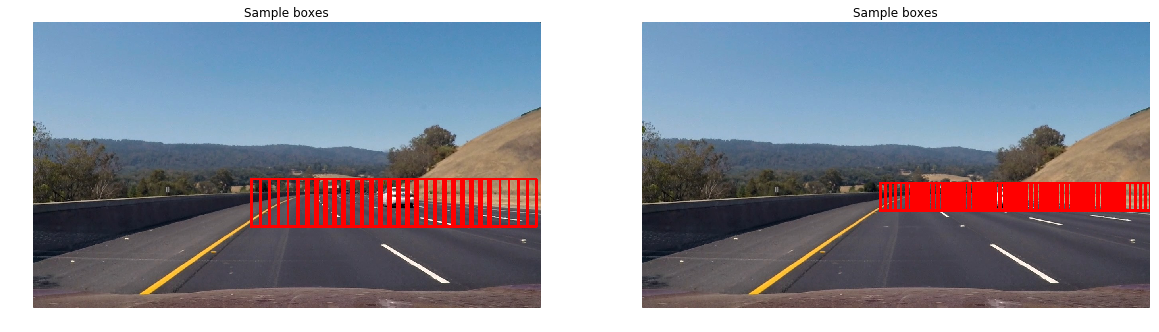

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.ravel()
combined_img = np.copy(test_images[0])


y_start_stop=[380, 620]
x_start_stop=[450, None]
xy_window=(240, 240)
color=(0, 0, 255)

axs[0].imshow(sample_image_slicing(test_images[5], jpg=False, xy_window=xy_window,
                                   y_start_stop=y_start_stop, color=color, x_start_stop=x_start_stop))
axs[0].axis('off')
axs[0].set_title("Sample boxes")

y_start_stop=[380, 570]
x_start_stop=[500, None]
xy_window=(180, 180)
color=(0, 255, 0)

axs[1].imshow(sample_image_slicing(test_images[5], jpg=False, xy_window=xy_window,
                                   y_start_stop=y_start_stop, color=color, x_start_stop=x_start_stop))
axs[1].axis('off')
axs[1].set_title("Sample boxes")

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
y_start_stop=[395, 525]
x_start_stop=[550, None]
xy_window=(120, 120)
color=(255, 0, 0)


axs[0].imshow(sample_image_slicing(test_images[5], jpg=False, xy_window=xy_window,
                                   y_start_stop=y_start_stop, color=color, x_start_stop=x_start_stop))
axs[0].axis('off')
axs[0].set_title("Sample boxes")

y_start_stop=[405, 480]
x_start_stop=[600, None]
y_start_stop=[405, 475]
xy_window=(70, 70)


axs[1].imshow(sample_image_slicing(test_images[5], jpg=False, xy_window=xy_window,
                                    y_start_stop=y_start_stop, color=color, x_start_stop=x_start_stop))
axs[1].axis('off')
axs[1].set_title("Sample boxes")


axs[1].axis('off')
axs[1].set_title("Sample boxes")

In [170]:
# This function is used to combine several windows. These windows are used to identify cars in the image
def combine_windows(image, jpg=True):

    combined_windows = []

    y_start_stop=[380, 570]
    x_start_stop=[450, None]
    xy_window=(180, 180)
    
    img_windows_1 = search_cars_windows(image, jpg=jpg, xy_window=xy_window,
                                         y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    combined_windows.append(img_windows_1)
    
    y_start_stop=[395, 525]
    x_start_stop=[500, None]
    xy_window=(120, 120)
    
    img_windows_2 = search_cars_windows(image, jpg=jpg, xy_window=xy_window,
                                         y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    combined_windows.append(img_windows_2)
    
    y_start_stop=[405, 475]
    x_start_stop=[550, None]
    xy_window=(70, 70)
    
    img_windows_3 = search_cars_windows(image, jpg=jpg, xy_window=xy_window,
                                        y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    combined_windows.append(img_windows_3)
    
    y_start_stop=[400, 470]
    x_start_stop=[610, None]
    xy_window=(70, 70)
    
    img_windows_4 = search_cars_windows(image, jpg=jpg, xy_window=xy_window,
                                        y_start_stop=y_start_stop, x_start_stop=x_start_stop)
    combined_windows.append(img_windows_4)
    
    return combined_windows

In [171]:
# Get the windows where a car is found
def find_cars_windows(image, jpg=True):
    car_windows = combine_windows(image, jpg=jpg)
    car_windows = [window for sublist in car_windows for window in sublist] 
    return car_windows

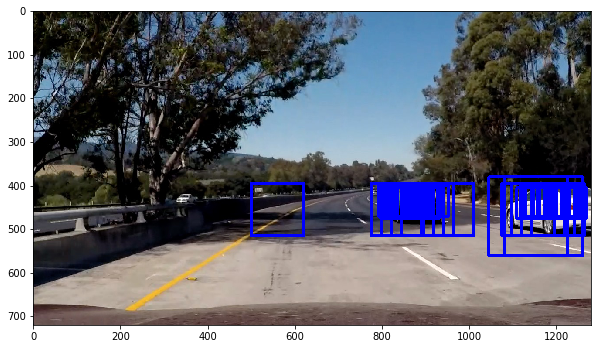

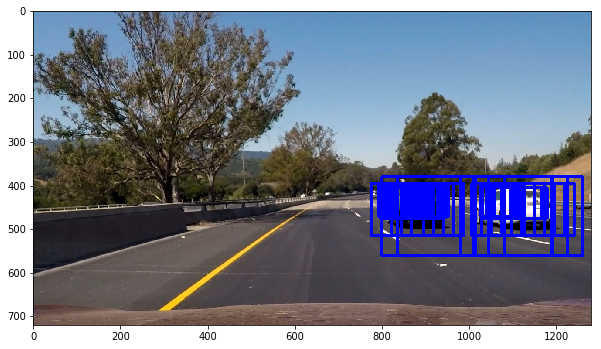

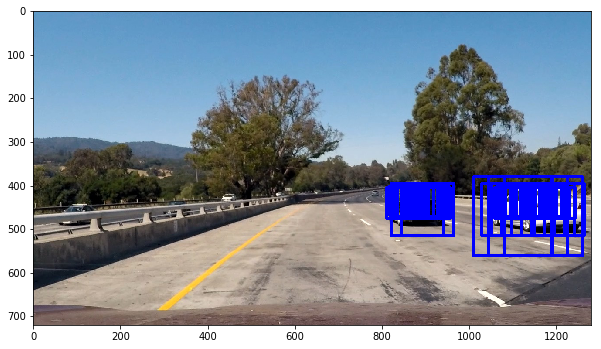

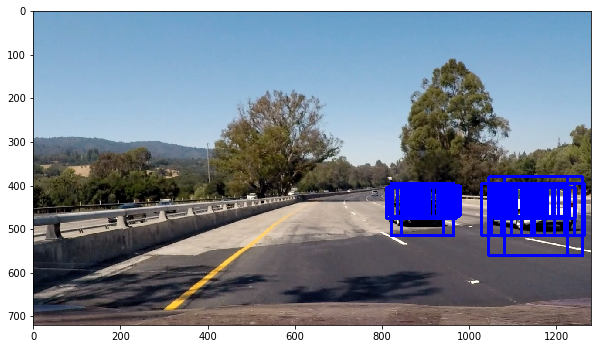

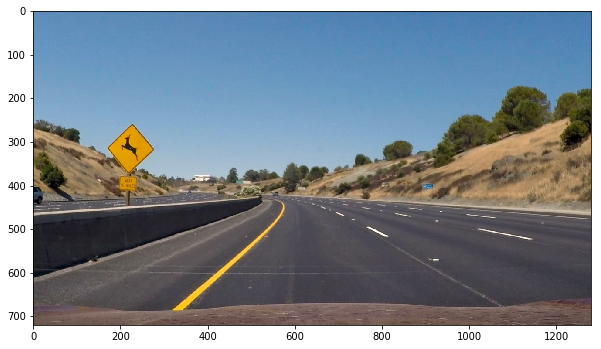

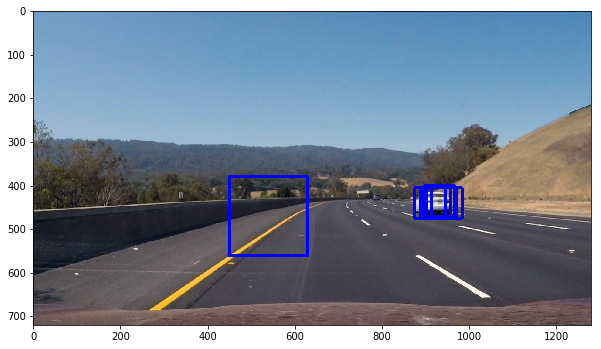

In [172]:
# Show test examples car detection
for image in test_images:
    car_windows = find_cars_windows(image, jpg=True)
    car_image = draw_boxes(image, car_windows, thick=6)
    plt.figure(figsize=(10,10))
    plt.imshow(car_image)

In [173]:
# Function that creates a heatmap based on the input boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [174]:
# Apply a threshold of the input heatmap to discard false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [175]:
# Draw final image. It creates a rectangle on top of the cars
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

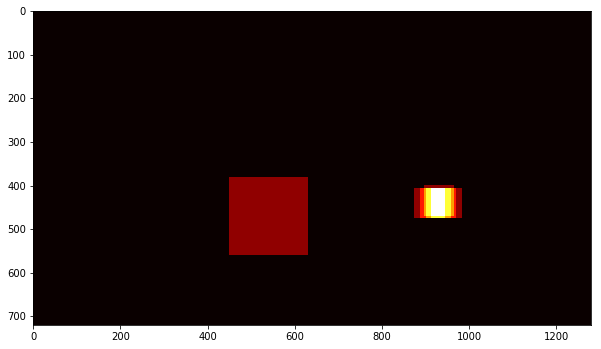

In [176]:
image = test_images[5]
rectangles = find_cars_windows(image, jpg=True)
heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

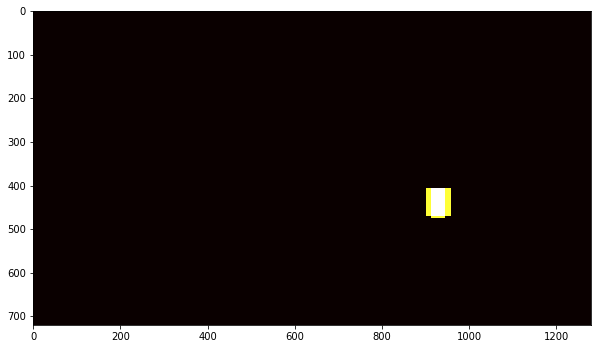

In [177]:
heatmap_img = apply_threshold(heatmap_img, 3)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

1 cars found


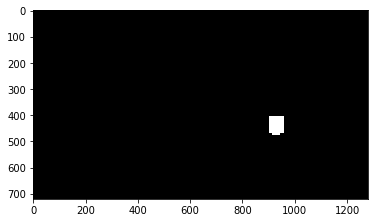

In [178]:
from scipy.ndimage.measurements import label
labels = label(heatmap_img)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

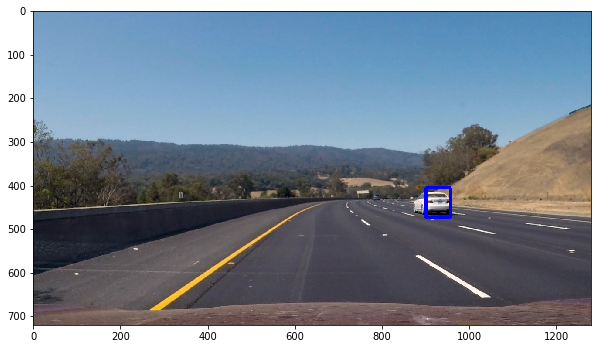

In [179]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [183]:
# Define the complete pipeline to process the video images
def video_pipeline(image):
    rectangles = find_cars_windows(image, jpg=True)
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 4)
    labels = label(heatmap_img)
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    return final_image

In [181]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [184]:
input_clip = VideoFileClip("test_video.mp4")
clip = input_clip.fl_image(video_pipeline)
clip.write_videofile("test_video_out.mp4", audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



In [187]:
input_clip = VideoFileClip("project_video.mp4")#.subclip(16,28)
clip = input_clip.fl_image(video_pipeline)
clip.write_videofile("project_video_out.mp4", audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [13:02<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

